# Simultaneous Imitation

## Abstract
TODO

## Imitation Task
This is the video, subjects saw the video and imitated movements **simultaneously**.
<iframe width="560" height="315" src="https://www.youtube.com/embed/2hhV0Ev2PDQ"></iframe>


## Subject heatmap and Grand Average

We calculate the grand average data heatmap for fixation, data ranges are [0, 48] and [0, 30] for 
(x, y) respectively so we need to filter data as the next scatter plot shows.


97.96991508986682% of data inside this range


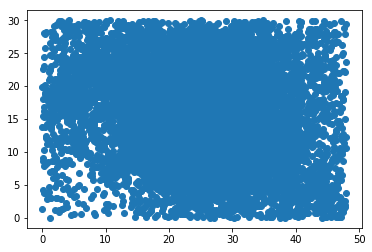

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./source_data/data.csv')

x0 = data['x_start']  # index = 2
y0 = data['y_start']  # index = 3

mask = [(x > 0) and (x < 48) and (y > 0) and (y < 30) for x, y in zip(x0, y0)]
print("{}% of data inside this range".format(100*sum(mask)/len(mask)))
plt.scatter(x0[mask], y0[mask])
plt.show()

## Creating a trial-only mask and modify x-y coordinates
From all data points we need to use only those points inside useful trial intervals so we need to mask them, we also
modify x-y coords that were normalized by 48, 30.

In [11]:
import pandas as pd
import numpy as np


# load data
data = pd.read_csv('./source_data/data.csv')
t0 = data['time_start'].as_matrix()
subject = data['subject'].as_matrix() - 1  # subject1 is 0 in python

trial_data = pd.read_excel('./source_data/Frames.xlsx')
ids = trial_data['id'].as_matrix()

# mark trials 1 to 5 with that number, passive observation as 0, -1 everything else
# take out the invalid subjects, marked with 0 as id
mask = [i for i in range(len(ids)) if ids[i] > 0]

# transform frame tags to time, videos were at 30fps
intervals = [(trial_data['passivei'].as_matrix()[mask]/30, trial_data['passivef'].as_matrix()[mask]/30), 
             (trial_data['t1i'].as_matrix()[mask]/30, trial_data['t1f'].as_matrix()[mask]/30), 
             (trial_data['t2i'].as_matrix()[mask]/30, trial_data['t2f'].as_matrix()[mask]/30), 
             (trial_data['t3i'].as_matrix()[mask]/30, trial_data['t3f'].as_matrix()[mask]/30), 
             (trial_data['t4i'].as_matrix()[mask]/30, trial_data['t4f'].as_matrix()[mask]/30), 
             (trial_data['t5i'].as_matrix()[mask]/30, trial_data['t5f'].as_matrix()[mask]/30)]

# start trial id at -1, which means outside of a trial
trial_id = np.zeros(t0.shape) - 1
for data_index in range(len(trial_id)):
    for tuple_index in range(len(intervals)):
        interval_low = intervals[tuple_index][0]
        interval_high = intervals[tuple_index][1]
        low = interval_low[subject[data_index]]
        high = interval_high[subject[data_index]]
        
        if low < t0[data_index] < high:
            trial_id[data_index] = tuple_index
            
# add this mask to data csv
data['trial_id'] = trial_id
# update normalized x-y data
data['x_start'] = data['x_start']/48
data['x_end'] = data['x_end']/48
data['y_start'] = data['y_start']/30
data['y_end'] = data['y_end']/30

# calculate percentage of data outside of a trial
ratio = np.sum(trial_id == -1) / len(trial_id) 
print("{}% of Data outside of trials".format(ratio*100))

# make a modified file
data.to_csv('./source_data/data_modified.csv')

/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19:

74.20369811646049% of Data outside of trials


## Fixation Heatmap
Taking re-normalized coords in mind we resize data to real monitor setting and we create the heatmap. Also we saved
normalized coords in the modified csv data file.


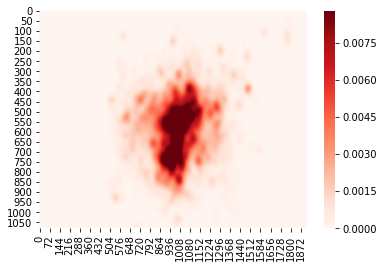

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import cv2


# modify here which tags we allow inside mask, eliminate numbers which you don't want in heatmap
events = [1, 2, 3]  # 1 - 2 - 3 = saccades - fixations - smooth pursuit
trials = [0, 1, 2, 3, 4, 5] # 0 = passive view

# import data
data = pd.read_csv('./source_data/data_modified.csv')
x0_resized = data['x_start']*1920
y0_resized = data['y_start']*1080
data_type = data['type']
trial_id = data['trial_id']
duration = data['duration']

# creating mask to subset data: tag = 1,2,3 - sacc,fix,sp; t_id = 0 to 5 according to trial id (0 is passive obs)
mask = [(x > 0) and (x < 1920) and (y > 0) and (y < 1080) and tag in events and t_id in trials for x, y, tag, t_id in 
        zip(x0_resized, y0_resized, data_type, trial_id)]

# translate vector to a heatmap matrix
heatmap = np.zeros((1080, 1920))
for x, y, t, valid in zip(x0_resized, y0_resized, duration, mask):
    if valid:
        heatmap[int(y), int(x)] += t

# gaussian filter heatmap
blurred_heatmap = cv2.GaussianBlur(heatmap, (0, 0), 20)

# show the beauty
sb.heatmap(blurred_heatmap, cmap='Reds', robust=True)
plt.show()

## Fixation/Saccade/SmoothPursuit Characterization Overview

We calculate mean fixation duration and number as grand-average to check differences with other studies.

Grand average fix 0.35375081353631066
Grand average sacc 0.05851383952482124
Grand average smooth 0.9650315557224927


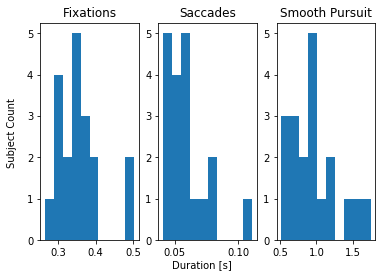

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# create a function that averages duration per subject
def group_average(dataframe, event_id, avg_type='duration'):
    durations = dataframe['duration']
    subject_mask = dataframe['subject']
    type_mask = dataframe['type'] 
    trial_mask = dataframe['trial_id']
    n_subjects = subject_mask.max()
    mean_data = np.empty(n_subjects)
    
    for n in range(n_subjects):
        subject_data = [_t for index, _t in enumerate(durations) 
                        if subject_mask[index] == n+1 and type_mask[index] == event_id and trial_mask[index] >= 0]
        if type == 'quantity':
            mean_data[n] = len(subject_data)
        elif type == 'duration':
            mean_data[n] = np.nanmean(subject_data)
        else: 
            Warning("{} is not a possible type argument, pick quantity or duration, "
                    "using duration as default".format(avg_type))
            mean_data[n] = np.nanmean(subject_data)
    return mean_data


# import data
data = pd.read_csv('./source_data/data_modified.csv')

# average events
data_type = dict(sacc=1, fix=2, smp=3)  # smp = smooth pursuit
sacc_duration = group_average(data, data_type['sacc'])
fix_duration = group_average(data, data_type['fix'])
smp_duration = group_average(data, data_type['smp'])

print("Grand average fix {}".format(np.nanmean(fix_duration)))
print("Grand average sacc {}".format(np.nanmean(sacc_duration)))
print("Grand average smooth {}".format(np.nanmean(smp_duration)))

# plot average duration for subjects histogram
fig, axes = plt.subplots(1, 3)
axes[0].hist(fix_duration)
axes[0].set_title("Fixations")
axes[1].hist(sacc_duration)
axes[1].set_title("Saccades")
axes[2].hist(smp_duration)
axes[2].set_title("Smooth Pursuit")

# Set common labels
fig.text(0.5, 0.04, 'Duration [s]', ha='center', va='center')
fig.text(0.06, 0.5, 'Subject Count', ha='center', va='center', rotation='vertical')

plt.savefig("average_durations.png", dpi=1000)
plt.show()

## Calculate Fix-Sacc-SmoothP per Trial


In [1]:
import pandas as pd
import seaborn as sns
# import statsmodels.api as sm
from statsmodels.formula.api import ols


# import data
data = pd.read_csv('./source_data/data_modified.csv')
data_type = data['type']
trial_id = data['trial_id']
duration = data['duration']
subject_id = data['subject']

data_list = []  # save subject, trial, duration
for trial in range(6):
    for subject in range(20):
        # tag: 1 - sacc; 2 - fix; 3 - sp
        sub_times = [a_time for a_time, sub, tag, t_id in zip(duration, subject_id, data_type, trial_id)
                 if sub == subject and tag == 3 and t_id == trial]
        data_list.append([subject, trial, len(sub_times)])  # append np.nanmean or len for duration/quantity

# summarize into a dataframe
grand_averages = pd.DataFrame(data_list, columns=["Subject", "Trial", "Quantity"])
point_plot = \
    sns.pointplot(x="Trial", y="Quantity", data = grand_averages).set_title("Smooth Pursuit quantity per trial")
fig = point_plot.get_figure()
fig.savefig("sp_quantity_trials.png", dpi=1000)

# apply ANOVA for significance
anova = ols('Quantity ~ C(Trial)', data=grand_averages).fit()
anova.summary()
# aov_table = sm.stats.anova_lm(anova, typ=2)
# aov_table

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.722
Date:                Sun, 01 Dec 2019   Prob (F-statistic):             0.0231
Time:                        09:18:29   Log-Likelihood:                -323.71
No. Observations:                 120   AIC:                             659.4
Df Residuals:                     114   BIC:                             676.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.3500      0.824      6.493      0.000       3.718       6.982
C(Trial)[T.1]     2.4000      1.165      2.059      0.042       0.091       4.709
C(Trial)[T.2]     3.6000      1.165      3.089      0.003       1.291       5.909
C(Trial)[T.3]     3.1000      1.165      2.660      0.009       0.791       5.409
C(Trial)[T.4]     3.3500      1.165      2.875      0.005       1.041       5.659
C(Trial)[T.5]     3.4000      1.165      2.918      0.004       1.091       5.709
==============================================================================
Omnibus:                        2.733   Durbin-Watson:                   1.638
Prob(Omnibus):                  0.255   Jarque-Bera (JB):                2.614
Skew:                          -0.359   Prob(JB):                        0.271
Kurtosis:                       2.915   Cond. No.                         6.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Add the ROI tag

/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


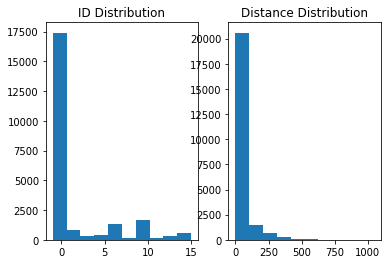

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


# import data and tracking annotations
data = pd.read_csv('./source_data/data_modified.csv')
tracking_path = './source_data/tracking/'
file_list = os.listdir(tracking_path)

tracking_container = [pd.read_csv(tracking_path + a_file, delimiter='\t') for a_file in file_list]
# for each data x-y point we need TTL + time = real time and check best distance to a ROI
# load TTL data
trial_data = pd.read_excel('./source_data/Frames.xlsx')
TTL = trial_data['TTL'].as_matrix()
valid_ids = trial_data['id']

# pick TTL only to those counted as valid subjects (id > 0)
TTL = [a_ttl for a_ttl, valid in zip(TTL, valid_ids) if valid > 0]
screen_ROI_ids = []
looked_ROI_ids = []
looked_ROI_distances = []

# remember x-y coords are normalized!
for t, x, y, subject, trial_id in zip(data['time_start'], data['x_start']*1920, data['y_start']*1080, 
                                      data['subject'], data['trial_id']):
    my_TTL = TTL[subject - 1]  # subject starts at 1 but index at 0
    # check for this data point the nearest ROI
    ROI_id = -1
    ROI_distance = -1
    if trial_id < 0:  # value not inside trial we just append -1 as it's non-valid
        screen_ROI_ids.append(ROI_id)
        looked_ROI_ids.append(ROI_id)
        looked_ROI_distances.append(ROI_distance)
        continue
    
    # for a valid trial we need the starting time to check the relative time to the video
    # this gives the correct excel column
    frame_vector = trial_data.as_matrix(columns=[trial_data.columns[3 + 2*trial_id]])
    # this takes invalid subjects out
    frame_vector = [a_frame_value[0] for a_frame_value, valid in zip(frame_vector, valid_ids) if valid > 0] 
    # with starting frame use time instead (video at 30 fps)
    video_start_time = frame_vector[subject - 1]/30
    current_time = t - video_start_time
    
    for ROI_index, a_ROI in enumerate(tracking_container):
        # check nearest roi and moving roi
        roi_times = a_ROI['t']
        match_threshold = 0.033  # this time dif means we're on this time
        match_index = -1
        for an_index, a_time in enumerate(roi_times):
            if np.abs(a_time - current_time) < match_threshold:
                match_index = an_index
                break
        # calculate distance to this ROI
        if match_index < 0:
            continue
        my_distance = np.hypot((np.abs(x - a_ROI['pixel_{x}'][match_index]*1920/640)), 
                               (np.abs(y - a_ROI['pixel_{y}'][match_index]*1080/480)))
        
        if ROI_distance < 0 or my_distance < ROI_distance:
            # update values
            ROI_distance = my_distance
            ROI_id = ROI_index
            
    # save final best roi
    screen_ROI_ids.append(ROI_id)
    looked_ROI_ids.append(ROI_id)
    looked_ROI_distances.append(ROI_distance)
    
# add ROI id and ROI distance to data
data['ROI_id'] = looked_ROI_ids
data['ROI_distance'] = looked_ROI_distances
data.to_csv('./source_data/data_modified.csv')

# check ROI distance and tag distribution
fig, axes = plt.subplots(1, 2)
axes[0].hist(looked_ROI_ids)
axes[0].set_title('ID Distribution')

axes[1].hist(looked_ROI_distances)
axes[1].set_title('Distance Distribution')

plt.show()

## Percentage of eye movements inside a ROI
We calculate some stats to check eye-ROI behaviour: First, we calculate percentage inside of any ROI per trial
and then we calculate percentages but for every different ROI.

In [1]:
import numpy as np
import pandas as pd
import os

# load data
tracking_path = './source_data/tracking/'
file_list = os.listdir(tracking_path)  # ROI id order 
data = pd.read_csv('./source_data/data_modified.csv')
ROI_ids = data['ROI_id'].as_matrix()
ROI_distances = data['ROI_distance'].as_matrix()
trial_ids = data['trial_id'].as_matrix()

# make a primitive count of each ROI region 
ROI_count = np.zeros(len(file_list))
for roi_id, trial_id in zip(ROI_ids, trial_ids):
    if trial_id > 0 and roi_id >= 0:
        ROI_count[roi_id] += 1

# normalize ROI count
ratio = 100*ROI_count/np.sum(ROI_count)
for a_name, a_ratio in zip(file_list, ratio):
    print("{} : {}".format(a_name, a_ratio))

right_hand.txt : 3.292181069958848
left_knee.txt : 10.758377425044092
right_elbow.txt : 2.900254752106604
left_hip.txt : 5.604546345287086
right_hip.txt : 3.017832647462277
pelvis.txt : 3.742896335488928
left_hand.txt : 22.790515383107977
right_knee.txt : 2.3319615912208507
right_foot.txt : 0.29394473838918284
center.txt : 21.732314324906916
left_shoulder.txt : 5.702527924750147
left_foot.txt : 3.096217911032726
thorax.txt : 3.6057221242406428
right_shoulder.txt : 1.7440721144424849
head.txt : 0.5486968449931413
left_elbow.txt : 8.837938467568097


/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/harrisonford/PycharmProjects/accelerometer-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


## Cut acc signal according to trials frames (checkout if matlab was done right)
First cut model signal and explore the idea of plotting signal peak values

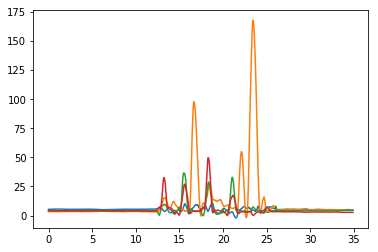

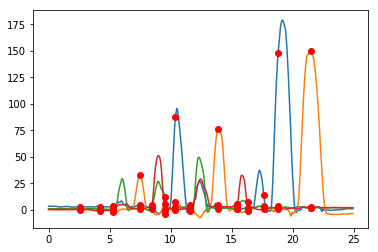

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy import signal


# load sensor data
data=scipy.io.loadmat('./source_data/myodatasum.mat')

# plot model signal
subModeltrial1 =  data['eventData_model']
sub18trial4 = data['eventData2'][18, 4]
times = np.linspace(0,(1./100.)*len(sub18trial4), num=len(sub18trial4))
plt.figure()
plt.plot(times, sub18trial4)

# plot signal peaks
data = subModeltrial1
time = np.linspace(0,(1./100.)*len(data), num=len(data))
peakind = signal.argrelmax(data[:, 1], order=40, mode='clip')

plt.figure()
plt.plot(time, data)
plt.plot(time[peakind], data[peakind], 'ro')

## Calculate signal of one subject in one trial

In [18]:
%pylab
%matplotlib notebook
import scipy.io
from scipy import signal
import matplotlib.pyplot as plt


# load signal data
data=scipy.io.loadmat('./source_data/myodatasum.mat')

# eventData2 options: 'numsubjects' 0-18 & numtrial 0-4
subModeltrial1 =  data['eventData_model']
peaksmodel = signal.argrelmax(data['eventData_model'], order=40, mode='clip')
sub18trial4 = data['eventData2'][18, 4]

figure()
plot(sub18trial4)
legend(['1','2','3','4'])
show()

figure()
plot(subModeltrial1)
legend(['1','2','3','4'])
show()

ModuleNotFoundError: No module named 'tkinter'

## Calculate Performance Using Peaks
We calculate performance peaks in 4 sensors (per subject, per trial, grand average)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

datamodel = pd.read_csv('./source_data/peaksamplitudemodel.csv')
datasubjects = pd.read_csv('./source_data/peaksamplitude.csv')

trial1 = datasubjects.iloc[:, 0:datamodel.size]
trial2 = datasubjects.iloc[:, datamodel.size*1:datamodel.size*2]
trial3 = datasubjects.iloc[:, datamodel.size*2:datamodel.size*3]
trial4 = datasubjects.iloc[:, datamodel.size*3:datamodel.size*4]
trial5 = datasubjects.iloc[:, datamodel.size*4:datamodel.size*5]

# difference between trial X signals minus model behaviour
datmod = pd.concat([datamodel]*19, ignore_index=True)
dm_t1 = datmod - trial1

datmod.columns = trial2.columns
dm_t2 = datmod - trial2

datmod.columns = trial3.columns
dm_t3 = datmod - trial3

datmod.columns = trial4.columns
dm_t4 = datmod - trial4

datmod.columns = trial5.columns
dm_t5 = datmod - trial5

# need to transfer labels from trial 1 to other trials
dm_t2.columns = dm_t1.columns
dm_t3.columns = dm_t1.columns
dm_t4.columns = dm_t1.columns
dm_t5.columns = dm_t1.columns

# we plot signal difference to check if performance is better
le = pd.concat([dm_t1.mean(), dm_t2.mean(), dm_t3.mean(), dm_t4.mean(), dm_t5.mean()], axis=1)
plt.figure()
le.T.plot()
plt.legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 0.5))


#le = pd.concat([dm_t1.mean(), dm_t2.mean(), dm_t3.mean(), dm_t4.mean(), dm_t5.mean()], axis=1)
plt.figure()
le.T.boxplot()

In [ ]:
## Calculate MSE performance of the whole signal
# TODO: I NEED PEAK FOR EACH SIGNAL FOR EACH SUBJECT
